# Wasserstein distance vs KL divergance

Toy models to check that the difference between the assesment of wasserstein and KL is in sensitivity of divergances in tails.



In [1]:
from scipy.stats import wasserstein_distance, norm
from matplotlib import pyplot as plt
import numpy as np


In [2]:
def select_n_points(n, x, center=True):
    if not n:
        return np.array([], dtype=int)
    if center:
        ps = norm.pdf(x, scale=0.5)
    else:
        ps = -norm.pdf(x, scale=1.5)
    probs = np.random.uniform(size=x.size)
    selected = np.argsort(ps*probs)[-n:]
    return selected
    

In [3]:


n=100_000
n_trials = 100
change = int(n/100)

colours = plt.cm.cool(np.linspace(0, 1, n_trials))
min_value = -15
max_value = 15
bins = np.arange(min_value, max_value, 0.5)



def generate_datasets(tail_shift, center_shift, suptitle):

    datasets = []
    base_datasets = []
    
    
    for i in range(n_trials):
        base = norm.rvs(size=n)
        moved = base.copy()
        
        if tail_shift == "mean":
            mean_shift = i/n_trials
            moved += mean_shift
        elif tail_shift == "std_grow":
            std_shift = 1 + i/n_trials
            moved *= std_shift
        elif tail_shift == "std_shrink":
            std_shift = (n_trials - i)/n_trials
            moved *= std_shift
        else:
            center_change = int(change*i/(n_trials-1))
            tail_change = change-center_change
            
            if center_shift is None:
                tail_change = center_change
            
            center_idxs = select_n_points(int(0.8*center_change), base, True)
            tail_idxs = select_n_points(tail_change, base, False)

            if center_shift is not None:
                moved[center_idxs] = center_shift(base[center_idxs])
            if tail_shift is not None:
                moved[tail_idxs] = tail_shift(base[tail_idxs])
            
        
        datasets += [moved]
        base_datasets += [base]
    
    # plotting
    
    hist_args = dict(histtype='step', bins=bins)
    
    fig, axarr = plt.subplots(2, 1, sharex=True)
    fig.suptitle(suptitle)
    
    base_bin_values, _, _  = axarr[0].hist(base_datasets[0], color='k', linewidth=5, **hist_args)
    bin_values, _ , _ = axarr[0].hist(datasets, color=colours, **hist_args)
    axarr[0].semilogy()
    axarr[0].set_ylabel("frequency")
    axarr[0].set_xlabel("x")
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    for c, vals in zip(colours, bin_values):
        axarr[1].hist(bin_centers, weights=vals-base_bin_values, color=c, **hist_args)
    
    if tail_shift is None or center_shift is None:
        axarr[0].plot([], [], c=colours[0], label='no change')
        axarr[0].plot([], [], c=colours[-1], label='max change')
    else:
        axarr[0].plot([], [], c=colours[0], label='change tails')
        axarr[0].plot([], [], c=colours[-1], label='change center')
    axarr[0].legend()
    
    axarr[1].set_ylabel("difference")
    
    probabilities = [np.histogram(ds, bins=bins, density=True)[0] for ds in datasets] 
    base_probabilities = [np.histogram(ds, bins=bins, density=True)[0] for ds in base_datasets] 

    return datasets, base_datasets, probabilities, base_probabilities



def kl_divergance(probs, base_probs):
    mask = (base_probs > 0)*(probs>0)
    return np.sum(probs[mask]*np.log(probs[mask]/base_probs[mask]))


In [4]:
def plots(suptitle, tail_shift, center_shift):

    datasets, base_datasets, probabilities, base_probabilities = generate_datasets(tail_shift, center_shift, suptitle)
    
    ws_distances = np.fromiter((wasserstein_distance(bs, ds) for bs, ds in zip(base_datasets, datasets)), dtype=float)
    
    kl_divs = np.fromiter((kl_divergance(ds, bs) for ds, bs in zip(probabilities, base_probabilities)), dtype=float)
        
    
    fig, axarr = plt.subplots(1, 2, figsize=(12, 4))
    
    axarr[0].scatter(ws_distances, kl_divs, c=colours)
    axarr[0].set_xlabel("KL divergance")
    axarr[0].set_ylabel("Wasserstein distance")

    if isinstance(tail_shift, str):
        change_type = ""
    elif tail_shift is None:
        change_type = "center "
    else:
        change_type = "tail "
    
    if center_shift is None or tail_shift is None:
        axarr[1].scatter([], [], c=colours[0], label='no change')
        axarr[1].scatter([], [], c=colours[-1], label=f'max {change_type}change')
        axarr[1].scatter(np.linspace(0, 1, n_trials), ws_distances/kl_divs, c=colours)
        axarr[1].set_xlabel(f"no change into max {change_type}change")
        axarr[1].set_ylabel("Wasserstein distance/KL divergance")
    else:
        axarr[1].scatter([], [], c=colours[0], label='change tails')
        axarr[1].scatter([], [], c=colours[-1], label='change center')
        axarr[1].scatter(np.linspace(0, 1, n_trials), ws_distances/kl_divs, c=colours)
        axarr[1].set_xlabel("ratio tail to center change")
        axarr[1].set_ylabel("Wasserstein distance/KL divergance")
    axarr[1].legend()
    fig.suptitle(suptitle)

In [5]:
def fixed(x):
    return np.ones(x.shape[0])*2

def no_op(x):
    return x


def shrink(x):
    return x*0.1

def grow(x):
    return x*2

def positive_sign(x):
    return np.abs(x)

def flatten_center(x):
    if x.shape[0] == 0:
        return x
    width = 2*np.std(x)
    return np.random.uniform(-width, width, x.shape[0])


def flatten_tails(x):
    if x.shape[0] == 0:
        return x
    distance = np.mean(np.abs(x))
    width = np.std(np.abs(x))
    return (distance + np.random.uniform(-width, width, x.shape[0]))*np.sign(x)
    

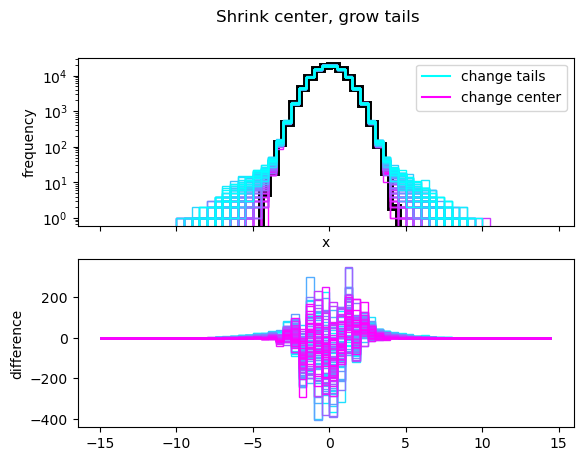

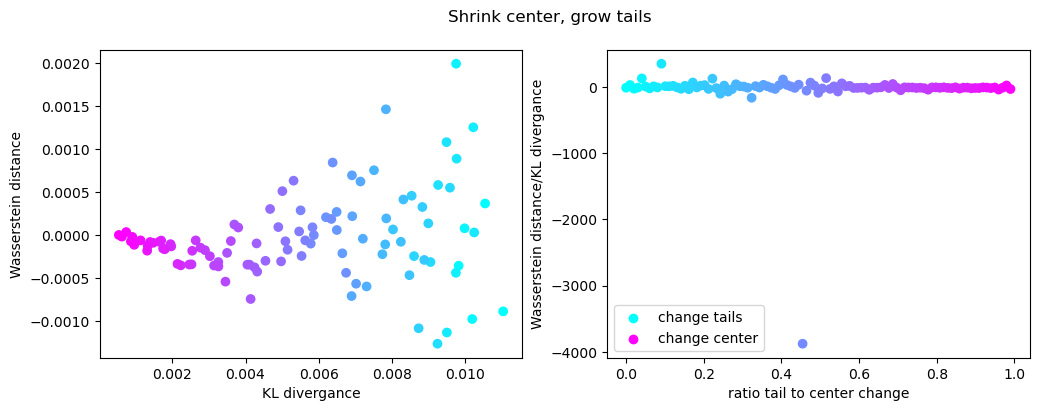

In [6]:
plots("Shrink center, grow tails", grow, shrink)

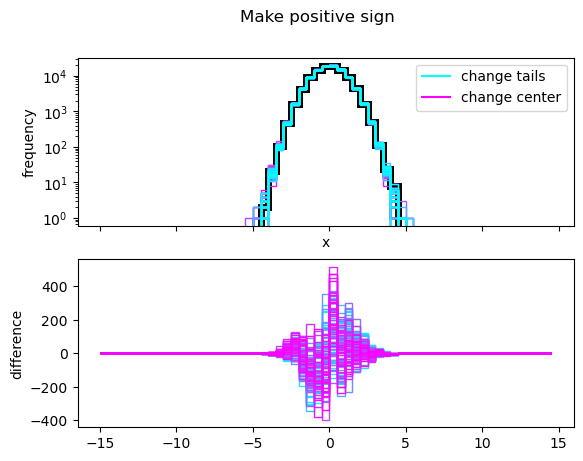

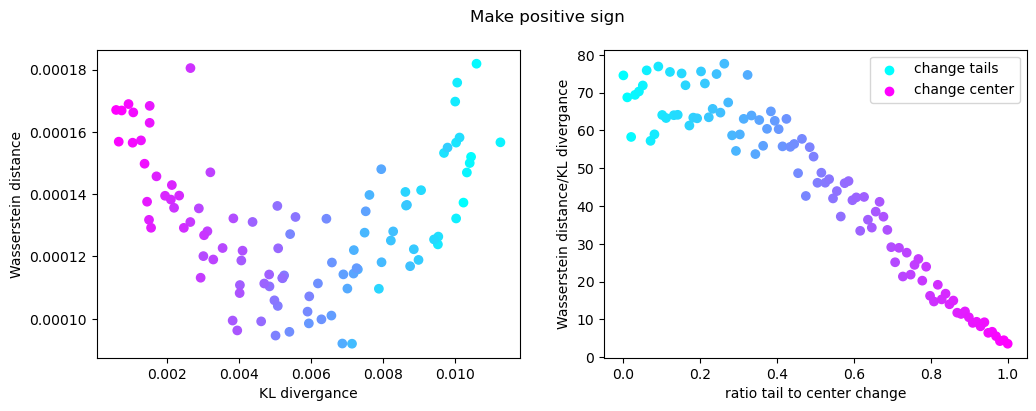

In [7]:
plots("Make positive sign", positive_sign, positive_sign)

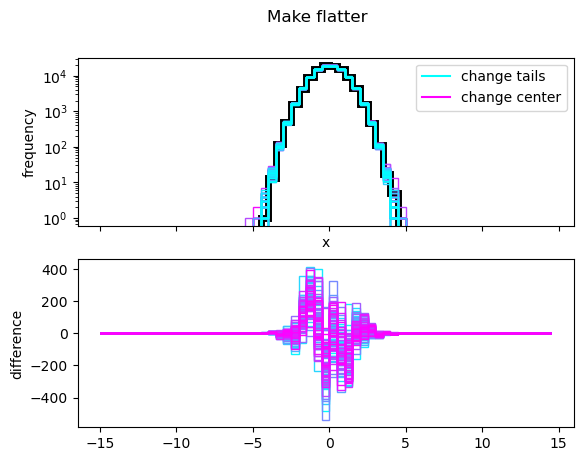

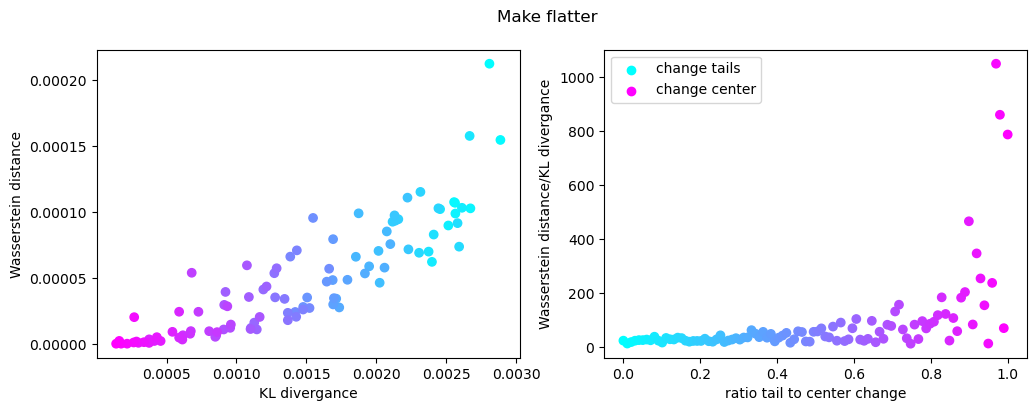

In [8]:
plots("Make flatter", flatten_tails, flatten_center)

In [9]:
from scipy.stats import wasserstein_distance
def wasserstein_d(u: np.ndarray, v: np.ndarray, weight_u: np.ndarray = None, weight_v: np.ndarray = None) -> float:
    """
    Calculate the normalized Wasserstein distance between two samples.
    
    Parameters:
    u (np.ndarray): Array of sample points from the first distribution.
    v (np.ndarray): Array of sample points from the second distribution.
    weight_u (np.ndarray, optional): Array of weights for the first sample. Default is None.
    weight_v (np.ndarray, optional): Array of weights for the second sample. Default is None.
    
    Returns:
    float: Normalized Wasserstein distance between the two distributions.
    """
    
    # Calculate the Wasserstein distance
    wasserstein_value = wasserstein_distance(u, v, weight_u, weight_v)
    
    # Compute standard deviation for normalization
    if weight_u is None:
        std_u = np.std(u, ddof=1)  # Using ddof=1 for unbiased estimate of standard deviation
    else:
        mean_u = np.average(u, weights=weight_u)
        variance_u = np.average((u - mean_u) ** 2, weights=weight_u)
        std_u = np.sqrt(variance_u)
    
    # Normalize Wasserstein distance
    if std_u != 0:
        wasserstein_value /= std_u
    else:
        raise ValueError("Standard deviation of the first distribution is zero, cannot normalize.")
    
    return wasserstein_value

from scipy.stats import entropy

def quantiled_kl_divergence(
    sample_ref: np.ndarray,
    sample_gen: np.ndarray,
    num_quantiles: int = 30,
):
    """Calculate the KL divergence using quantiles on sample_ref to define the bounds.

    Parameters
    ----------
    sample_ref : np.ndarray
        The first sample to compare (this is the reference, so in the context of
        jet generation, those are the real jets).
    sample_gen : np.ndarray
        The second sample to compare (this is the model/approximation, so in the
        context of jet generation, those are the generated jets).
    num_quantiles : int
        The number of bins to use for the histogram. Those bins are defined by
        equiprobably quantiles of sample_ref.
       
    """
    bin_edges = np.quantile(sample_ref, np.linspace(0, 1, num_quantiles + 1))
    bin_edges[0] = float("-inf")
    bin_edges[-1] = float("inf")
    pk = np.histogram(sample_ref, bin_edges)[0] / len(sample_ref) + 1e-6
    qk = np.histogram(sample_gen, bin_edges)[0] / len(sample_gen) + 1e-6
    kl = entropy(pk, qk)
    
    return kl


def plots2(suptitle, tail_shift, center_shift):

    datasets, base_datasets, probabilities, base_probabilities = generate_datasets(tail_shift, center_shift, suptitle)
    
    ws_distances = np.fromiter((wasserstein_d(bs, ds) for bs, ds in zip(base_datasets, datasets)), dtype=float)
    kl_divs = np.fromiter((quantiled_kl_divergence(bs, ds) for bs, ds in zip(base_datasets, datasets)), dtype=float)
    
        
    
    fig, axarr = plt.subplots(1, 2, figsize=(12, 4))
    
    axarr[0].scatter(ws_distances, kl_divs, c=colours)
    axarr[0].set_xlabel("KL divergance")
    axarr[0].set_ylabel("Wasserstein distance")
    
    
    if isinstance(tail_shift, str):
        change_type = ""
    elif tail_shift is None:
        change_type = "center "
    else:
        change_type = "tail "
    
    if center_shift is None or tail_shift is None:
        axarr[1].scatter([], [], c=colours[0], label='no change')
        axarr[1].scatter([], [], c=colours[-1], label=f'max {change_type}change')
        axarr[1].set_xlabel(f"no change into max {change_type}change")
    else:
        axarr[1].scatter([], [], c=colours[0], label='change tails')
        axarr[1].scatter([], [], c=colours[-1], label='change center')
        axarr[1].set_xlabel("ratio tail to center change")

    xs = np.linspace(0, 1, n_trials)
    ys = ws_distances/kl_divs
    axarr[1].scatter(xs, ys, c=colours)
    log_ys = np.log(ys)
    mask = (~np.isnan(log_ys))*(~np.isinf(log_ys))
    log_ys = log_ys[mask]
    xs = xs[mask]

    gradient, bias = np.polyfit(xs, log_ys, 1)
    
    axarr[1].set_ylabel(f"Wasserstein distance/KL divergance, grad_log={gradient:.3}")

    
        
    axarr[1].semilogy()
    axarr[1].legend()
    fig.suptitle(suptitle)

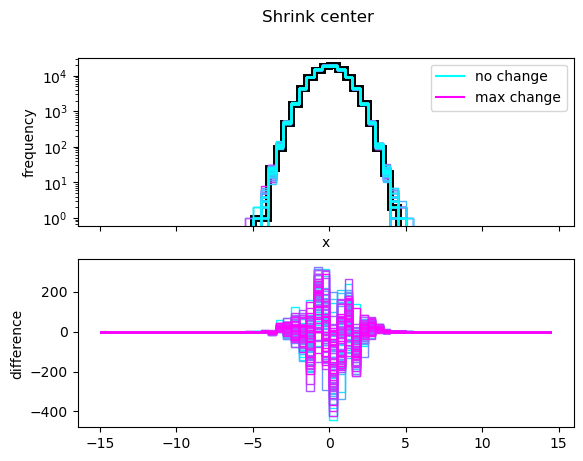

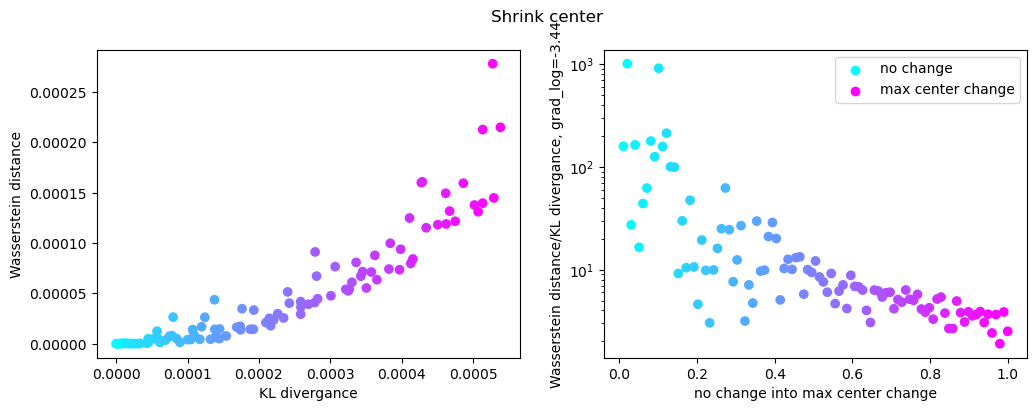

In [10]:
plots2("Shrink center", None, shrink)

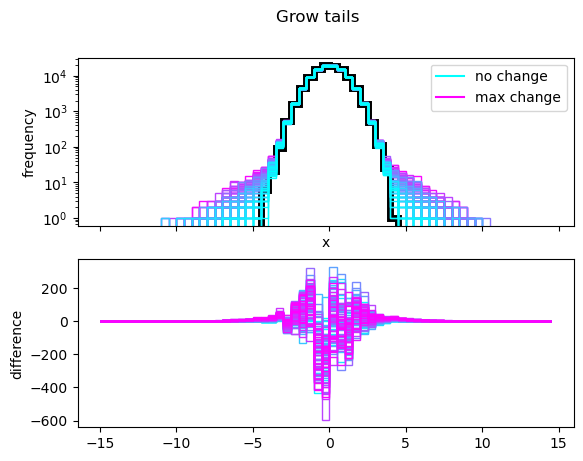

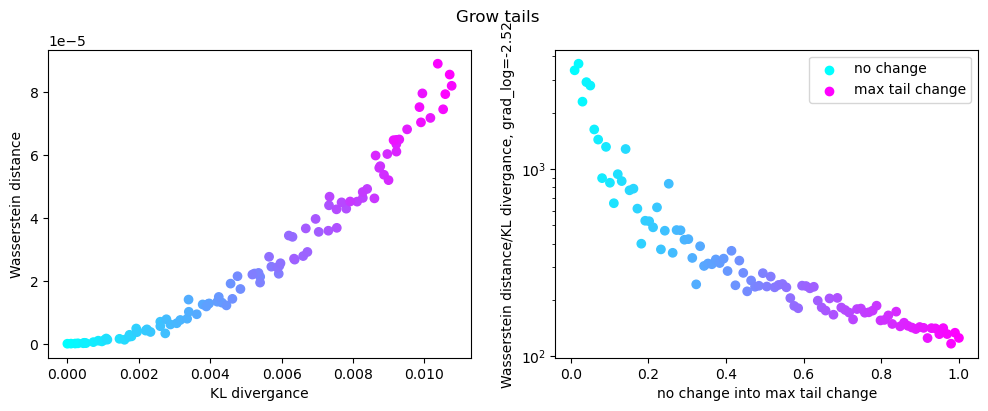

In [11]:
plots2("Grow tails", grow, None)

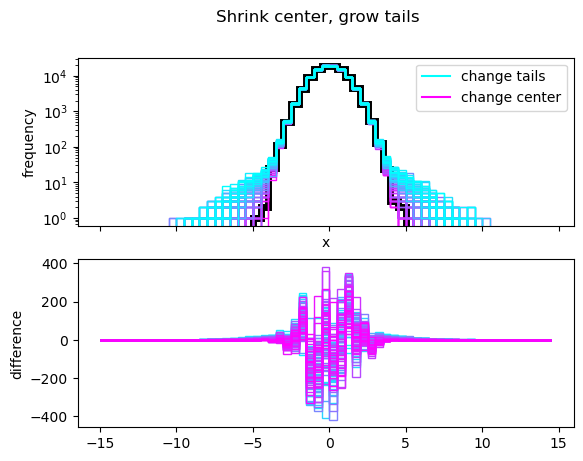

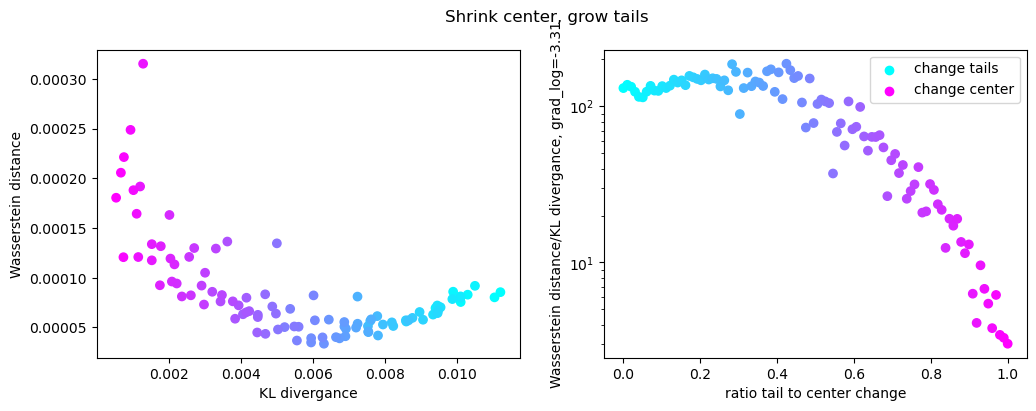

In [12]:
plots2("Shrink center, grow tails", grow, shrink)

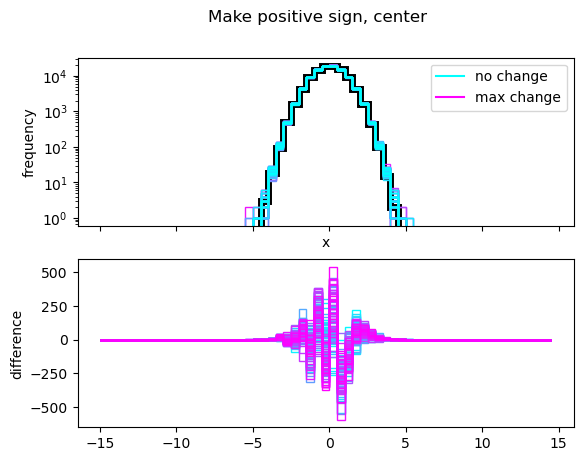

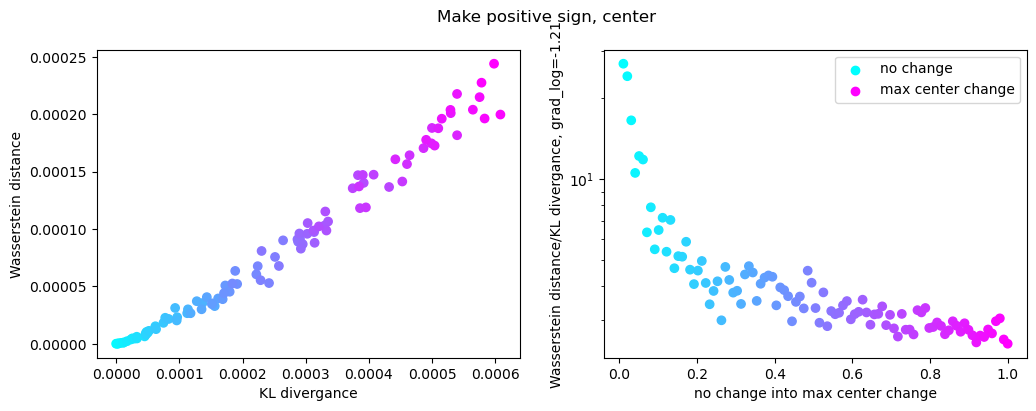

In [13]:
plots2("Make positive sign, center", None, positive_sign)

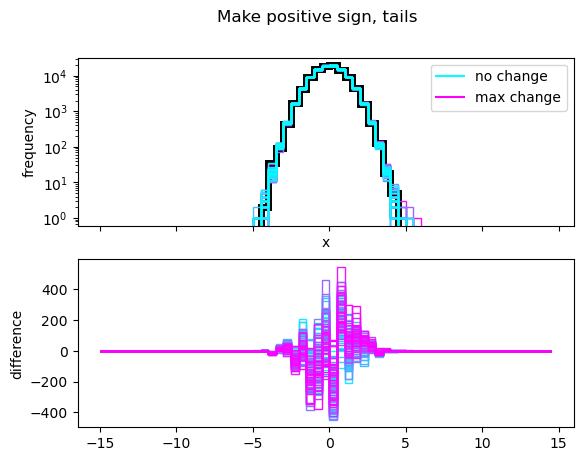

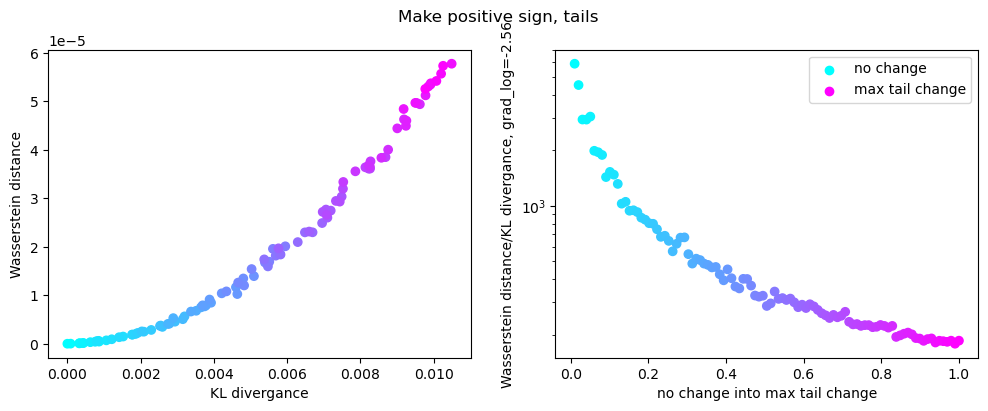

In [14]:
plots2("Make positive sign, tails", positive_sign, None)

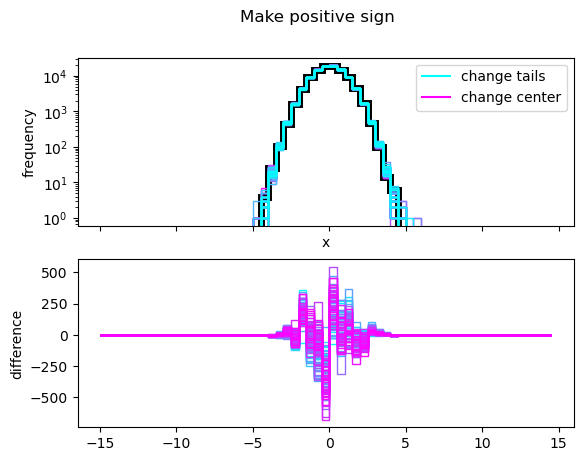

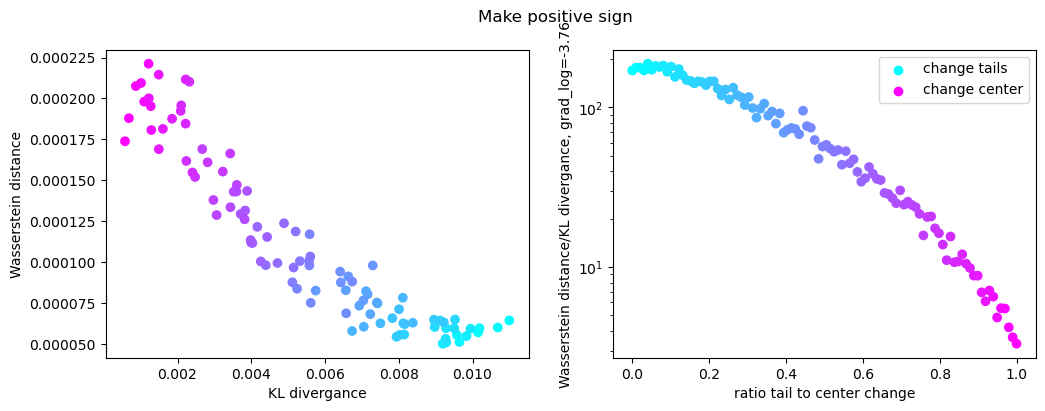

In [15]:
plots2("Make positive sign", positive_sign, positive_sign)

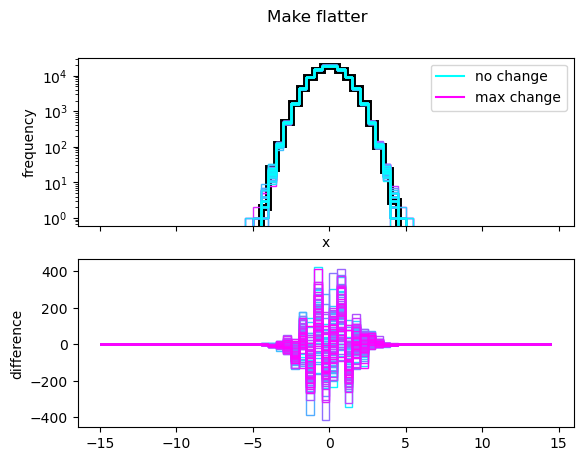

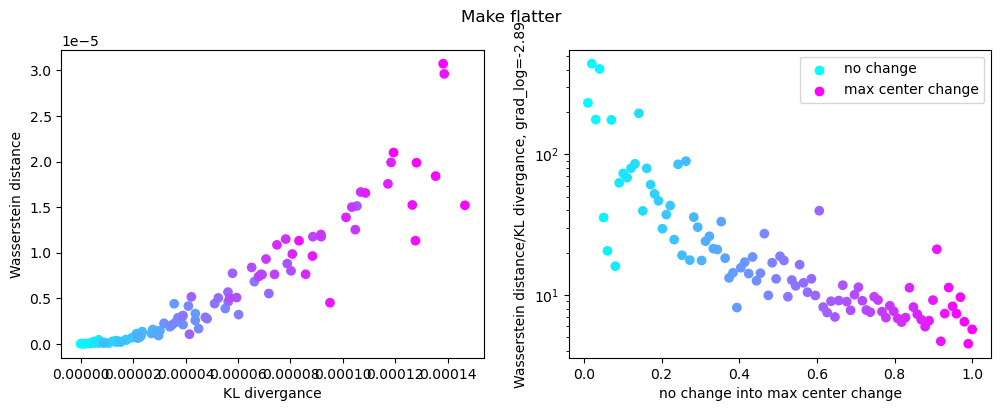

In [16]:
plots2("Make flatter", None, flatten_center)

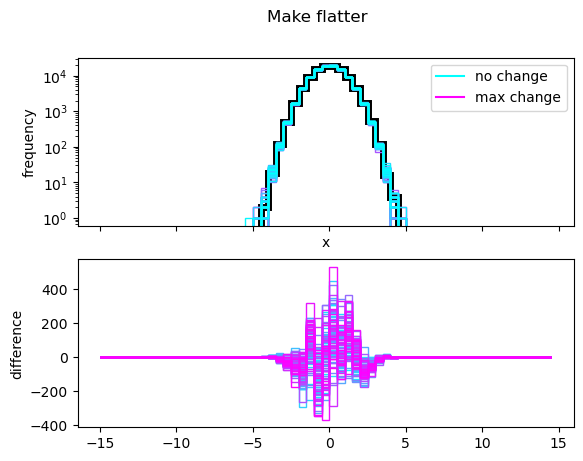

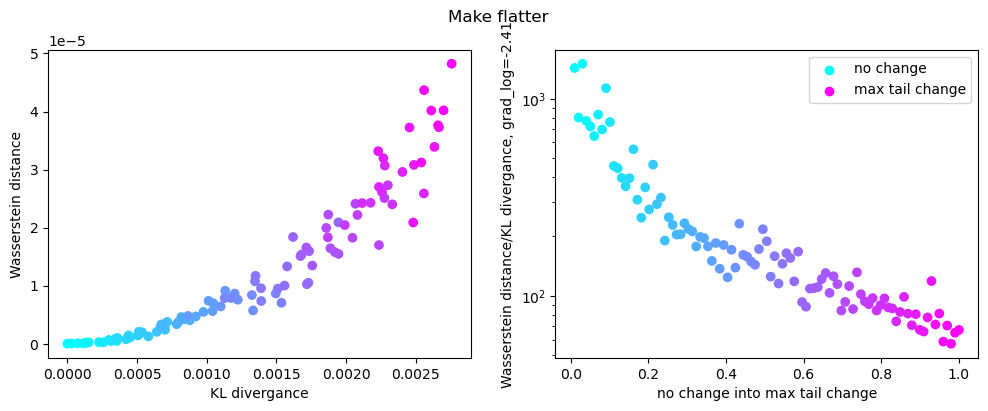

In [17]:
plots2("Make flatter", flatten_tails, None)

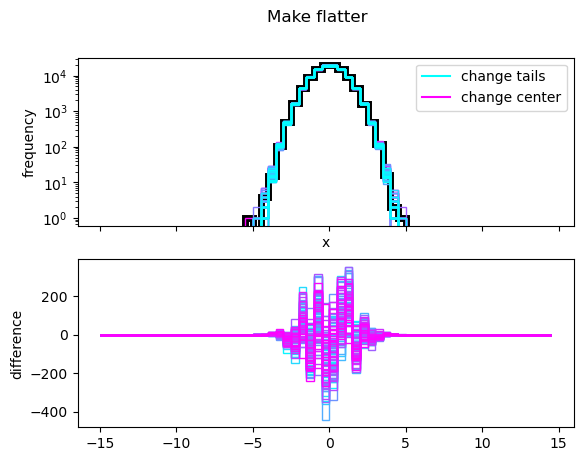

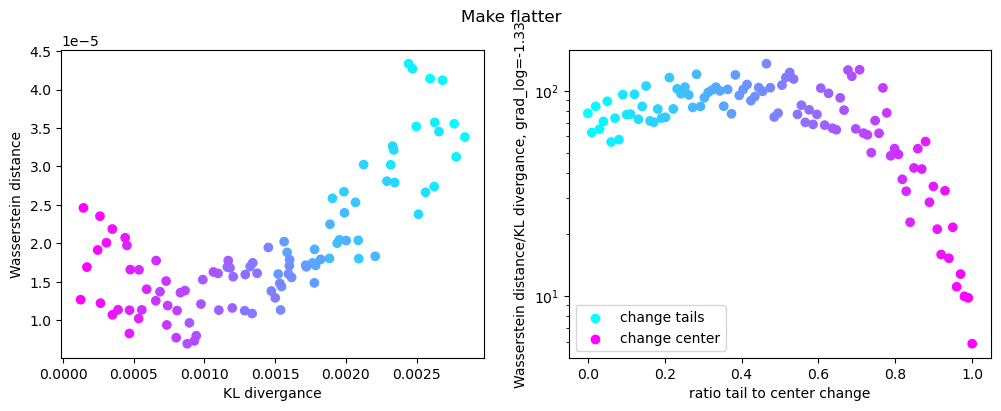

In [18]:
plots2("Make flatter", flatten_tails, flatten_center)

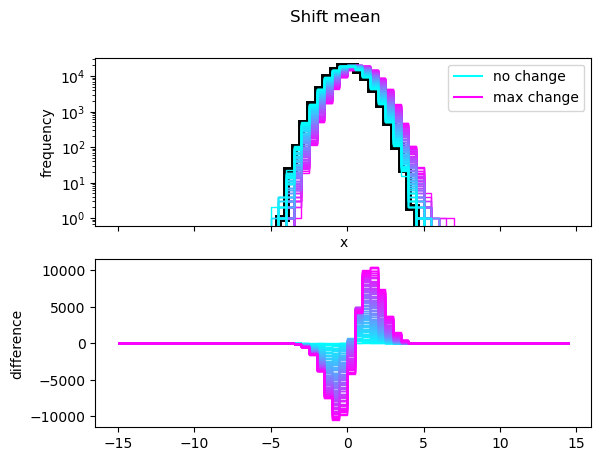

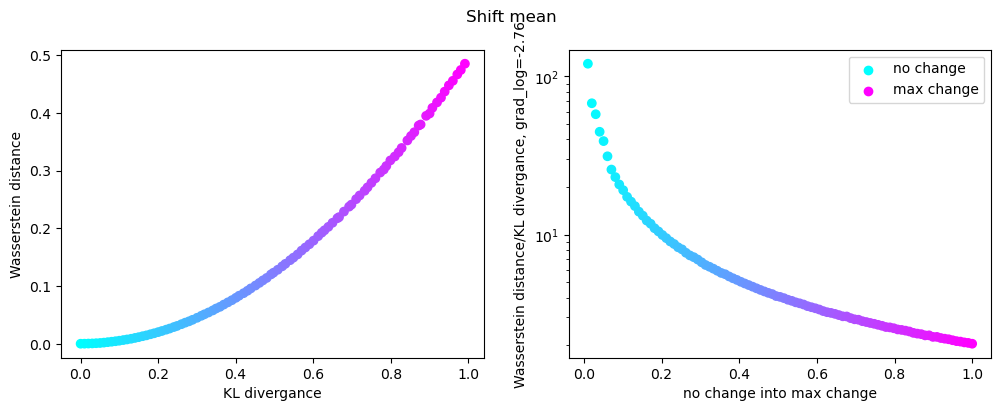

In [19]:
plots2("Shift mean", "mean", None)

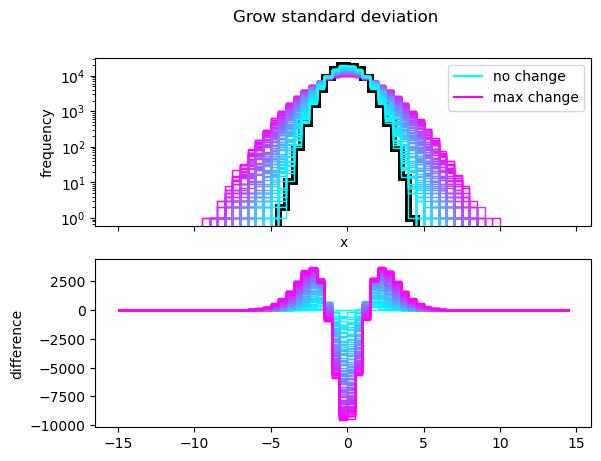

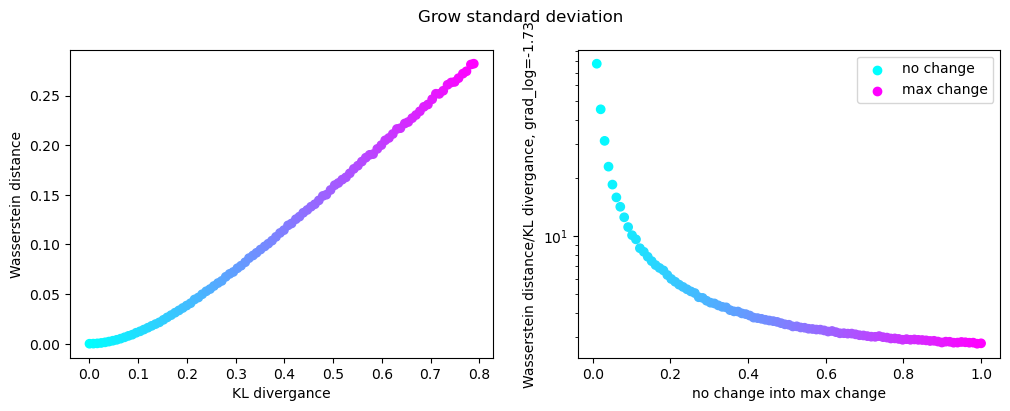

In [20]:
plots2("Grow standard deviation", "std_grow", None)

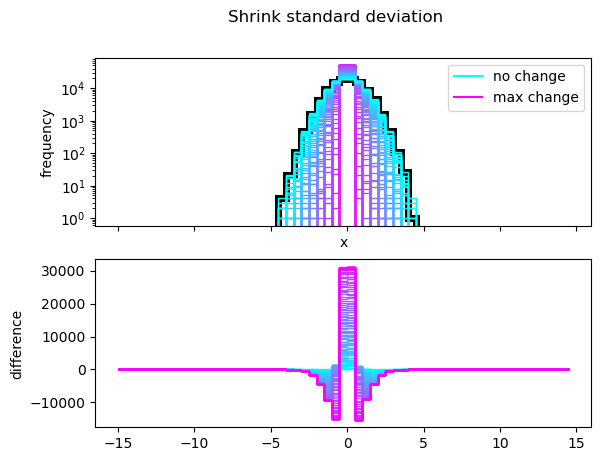

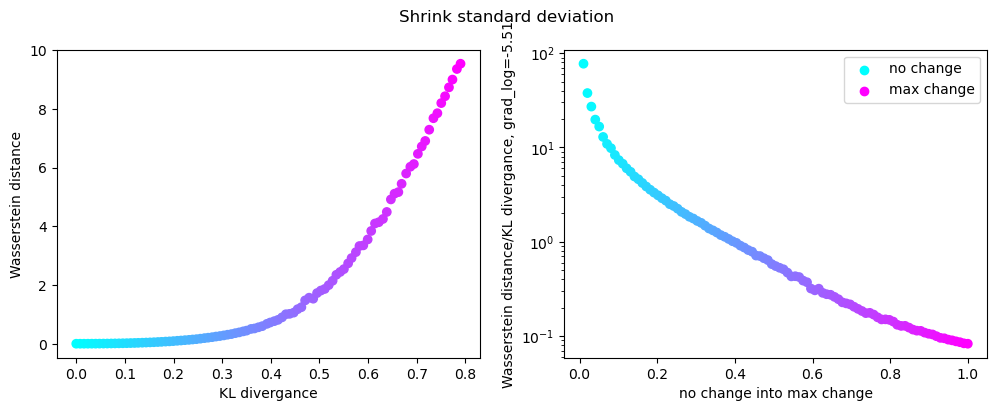

In [21]:
plots2("Shrink standard deviation", "std_shrink", None)